<a href="https://colab.research.google.com/github/arshad831/Community_Workshops-/blob/main/Customer_Segmentation_using_RFM_and_KMeans_Models/Customer_Segmentation_to_identify_Loyal_Customers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Import necessary libraries
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#Import Online Retail Data containing transactions from 01/12/2010 and 09/12/2011
Rtl_data = pd.read_csv('RetailData.csv', encoding = 'unicode_escape')
Rtl_data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12.0,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12.0,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12.0,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48.0,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24.0,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [3]:
#Check the shape (number of columns and rows) in the dataset
Rtl_data.shape

(388569, 8)

In [6]:
Rtl_data.rename(columns={'Customer ID': 'CustomerID'}, inplace=True)

In [7]:
#Customer distribution by country
country_cust_data=Rtl_data[['Country','CustomerID']].drop_duplicates()
country_cust_data.groupby(['Country'])['CustomerID'].aggregate('count').reset_index().sort_values('CustomerID', ascending=False)

,Country,CustomerID
35,United Kingdom,3492
12,Germany,61
11,France,40
29,Spain,21
22,Netherlands,19
26,Portugal,16
3,Belgium,15
30,Sweden,14
31,Switzerland,12
6,Channel Islands,11


In [8]:
#Keep only United Kingdom data
Rtl_data = Rtl_data.query("Country=='United Kingdom'").reset_index(drop=True)

In [9]:
#Check for missing values in the dataset
Rtl_data.isnull().sum(axis=0)

Invoice            0
StockCode          0
Description     2395
Quantity           0
InvoiceDate        0
Price              0
CustomerID     77504
Country            0
dtype: int64

In [10]:
#Remove missing values from CustomerID column, can ignore missing values in description column
Rtl_data = Rtl_data[pd.notnull(Rtl_data['CustomerID'])]

#Validate if there are any negative values in Quantity column
Rtl_data.Quantity.min()

-1440.0

In [11]:
Rtl_data.rename(columns={'Price': 'UnitPrice'}, inplace=True)

In [12]:
#Validate if there are any negative values in UnitPrice column
Rtl_data.UnitPrice.min()

0.0

In [13]:
#Filter out records with negative values
Rtl_data = Rtl_data[(Rtl_data['Quantity']>0)]

In [14]:
#Convert the string date field to datetime
Rtl_data['InvoiceDate'] = pd.to_datetime(Rtl_data['InvoiceDate'])

In [15]:
#Add new column depicting total amount
Rtl_data['TotalAmount'] = Rtl_data['Quantity'] * Rtl_data['UnitPrice']

In [16]:
#Check the shape (number of columns and rows) in the dataset after data is cleaned
Rtl_data.shape

(274723, 9)

In [17]:
Rtl_data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalAmount
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12.0,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12.0,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12.0,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48.0,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24.0,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0


## RFM Modelling

In [19]:
Rtl_data.rename(columns={'Invoice': 'InvoiceNo'}, inplace=True)

In [20]:
#Recency = Latest Date - Last Inovice Data, Frequency = count of invoice no. of transaction(s), Monetary = Sum of Total
#Amount for each customer
import datetime as dt

#Set Latest date 2011-12-10 as last invoice date was 2011-12-09. This is to calculate the number of days from recent purchase
Latest_Date = dt.datetime(2011,12,10)

#Create RFM Modelling scores for each customer
RFMScores = Rtl_data.groupby('CustomerID').agg({'InvoiceDate': lambda x: (Latest_Date - x.max()).days, 'InvoiceNo': lambda x: len(x), 'TotalAmount': lambda x: x.sum()})

#Convert Invoice Date into type int
RFMScores['InvoiceDate'] = RFMScores['InvoiceDate'].astype(int)

#Rename column names to Recency, Frequency and Monetary
RFMScores.rename(columns={'InvoiceDate': 'Recency',
                         'InvoiceNo': 'Frequency',
                         'TotalAmount': 'Monetary'}, inplace=True)

RFMScores.reset_index().head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,529,33,372.86
1,12745.0,486,22,723.85
2,12746.0,540,17,254.55
3,12747.0,424,140,4327.22
4,12748.0,423,1502,15078.20


In [21]:
#Descriptive Statistics (Recency)
RFMScores.Recency.describe()

count    3429.000000
mean      514.176436
std        87.814137
min       422.000000
25%       439.000000
50%       483.000000
75%       574.000000
max       738.000000
Name: Recency, dtype: float64

<ipython-input-22-68d424f9eecc>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(x)


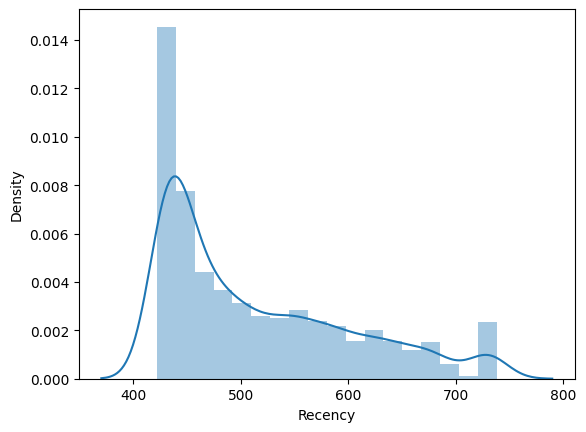

In [22]:
#Recency distribution plot
import seaborn as sns
x = RFMScores['Recency']

ax = sns.distplot(x)

In [23]:
#Descriptive Statistics (Frequency)
RFMScores.Frequency.describe()

count    3429.000000
mean       80.117527
std       156.232800
min         1.000000
25%        16.000000
50%        39.000000
75%        87.000000
max      4156.000000
Name: Frequency, dtype: float64

<ipython-input-24-eb2bc133a6ac>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(x)


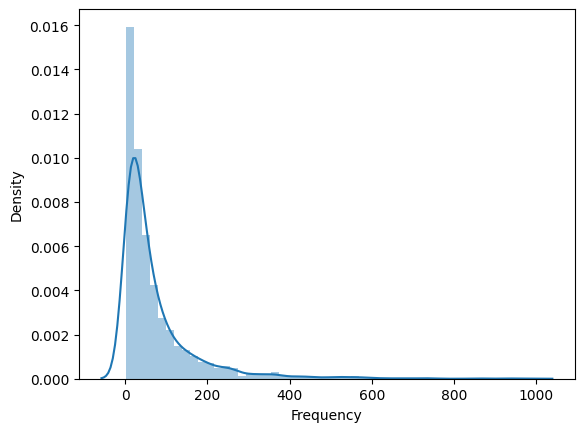

In [24]:
#Frequency distribution plot, taking observations which have frequency less than 1000
import seaborn as sns
x = RFMScores.query('Frequency < 1000')['Frequency']

ax = sns.distplot(x)

In [25]:
#Descriptive Statistics (Monetary)
RFMScores.Monetary.describe()

count      3429.000000
mean       1639.462161
std        6226.621141
min           0.000000
25%         275.400000
50%         611.600000
75%        1466.740000
max      269041.670000
Name: Monetary, dtype: float64

<ipython-input-26-29d9d328ee29>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(x)


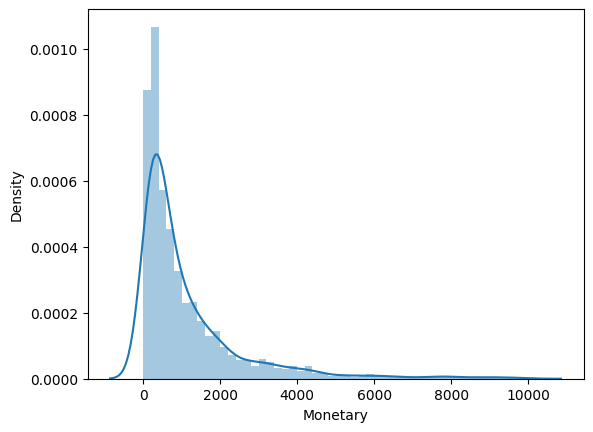

In [26]:
#Monateray distribution plot, taking observations which have monetary value less than 10000
import seaborn as sns
x = RFMScores.query('Monetary < 10000')['Monetary']

ax = sns.distplot(x)

In [27]:
#Split into four segments using quantiles
quantiles = RFMScores.quantile(q=[0.25,0.5,0.75])
quantiles = quantiles.to_dict()

In [ ]:
quantiles

{'Recency': {0.25: 17.0, 0.5: 50.0, 0.75: 142.0},
 'Frequency': {0.25: 17.0, 0.5: 41.0, 0.75: 99.0},
 'Monetary': {0.25: 300.03999999999996, 0.5: 651.8199999999999, 0.75: 1575.89}}

In [28]:
#Functions to create R, F and M segments
def RScoring(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]:
        return 3
    else:
        return 4

def FnMScoring(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]:
        return 2
    else:
        return 1

In [29]:
#Calculate Add R, F and M segment value columns in the existing dataset to show R, F and M segment values
RFMScores['R'] = RFMScores['Recency'].apply(RScoring, args=('Recency',quantiles,))
RFMScores['F'] = RFMScores['Frequency'].apply(FnMScoring, args=('Frequency',quantiles,))
RFMScores['M'] = RFMScores['Monetary'].apply(FnMScoring, args=('Monetary',quantiles,))
RFMScores.head()

,Recency,Frequency,Monetary,R,F,M
CustomerID,,,,,,
12346.0,529,33,372.86,3,3,3
12745.0,486,22,723.85,3,3,2
12746.0,540,17,254.55,3,3,4
12747.0,424,140,4327.22,1,1,1
12748.0,423,1502,15078.20,1,1,1


In [30]:
#Calculate and Add RFMGroup value column showing combined concatenated score of RFM
RFMScores['RFMGroup'] = RFMScores.R.map(str) + RFMScores.F.map(str) + RFMScores.M.map(str)

#Calculate and Add RFMScore value column showing total sum of RFMGroup values
RFMScores['RFMScore'] = RFMScores[['R', 'F', 'M']].sum(axis = 1)
RFMScores.head()

,Recency,Frequency,Monetary,R,F,M,RFMGroup,RFMScore
CustomerID,,,,,,,,
12346.0,529,33,372.86,3,3,3,333,9
12745.0,486,22,723.85,3,3,2,332,8
12746.0,540,17,254.55,3,3,4,334,10
12747.0,424,140,4327.22,1,1,1,111,3
12748.0,423,1502,15078.20,1,1,1,111,3


In [31]:
#Assign Loyalty Level to each customer
Loyalty_Level = ['Platinum', 'Gold', 'Silver', 'Bronze']
Score_cuts = pd.qcut(RFMScores.RFMScore, q = 4, labels = Loyalty_Level)
RFMScores['RFM_Loyalty_Level'] = Score_cuts.values
RFMScores.reset_index().head()

,CustomerID,Recency,Frequency,Monetary,R,F,M,RFMGroup,RFMScore,RFM_Loyalty_Level
0,12346.0,529,33,372.86,3,3,3,333,9,Silver
1,12745.0,486,22,723.85,3,3,2,332,8,Gold
2,12746.0,540,17,254.55,3,3,4,334,10,Silver
3,12747.0,424,140,4327.22,1,1,1,111,3,Platinum
4,12748.0,423,1502,15078.20,1,1,1,111,3,Platinum


In [32]:
#Validate the data for RFMGroup = 111
RFMScores[RFMScores['RFMGroup']=='111'].sort_values('Monetary', ascending=False).reset_index().head(10)

,CustomerID,Recency,Frequency,Monetary,R,F,M,RFMGroup,RFMScore,RFM_Loyalty_Level
0,13694.0,427,928,124621.35,1,1,1,111,3,Platinum
1,17511.0,436,751,66940.58,1,1,1,111,3,Platinum
2,15061.0,430,426,59890.81,1,1,1,111,3,Platinum
3,16754.0,427,133,56171.99,1,1,1,111,3,Platinum
4,15311.0,424,1642,49772.95,1,1,1,111,3,Platinum
5,17850.0,438,2202,45817.66,1,1,1,111,3,Platinum
6,13089.0,428,1351,43562.32,1,1,1,111,3,Platinum
7,12931.0,423,123,38878.08,1,1,1,111,3,Platinum
8,16029.0,427,119,34796.34,1,1,1,111,3,Platinum
9,14298.0,427,1075,34616.44,1,1,1,111,3,Platinum


In [33]:
pip install chart_studio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 kB 1.1 MB/s eta 0:00:00


In [34]:
import chart_studio as cs
import plotly.offline as po
import plotly.graph_objs as gobj

#Recency Vs Frequency
graph = RFMScores.query("Monetary < 50000 and Frequency < 2000")

plot_data = [
    gobj.Scatter(
        x=graph.query("RFM_Loyalty_Level == 'Bronze'")['Recency'],
        y=graph.query("RFM_Loyalty_Level == 'Bronze'")['Frequency'],
        mode='markers',
        name='Bronze',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        gobj.Scatter(
        x=graph.query("RFM_Loyalty_Level == 'Silver'")['Recency'],
        y=graph.query("RFM_Loyalty_Level == 'Silver'")['Frequency'],
        mode='markers',
        name='Silver',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        gobj.Scatter(
        x=graph.query("RFM_Loyalty_Level == 'Gold'")['Recency'],
        y=graph.query("RFM_Loyalty_Level == 'Gold'")['Frequency'],
        mode='markers',
        name='Gold',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
    gobj.Scatter(
        x=graph.query("RFM_Loyalty_Level == 'Platinum'")['Recency'],
        y=graph.query("RFM_Loyalty_Level == 'Platinum'")['Frequency'],
        mode='markers',
        name='Platinum',
        marker= dict(size= 13,
            line= dict(width=1),
            color= 'black',
            opacity= 0.9
           )
    ),
]

plot_layout = gobj.Layout(
        yaxis= {'title': "Frequency"},
        xaxis= {'title': "Recency"},
        title='Segments'
    )
fig = gobj.Figure(data=plot_data, layout=plot_layout)
po.iplot(fig)

#Frequency Vs Monetary
graph = RFMScores.query("Monetary < 50000 and Frequency < 2000")

plot_data = [
    gobj.Scatter(
        x=graph.query("RFM_Loyalty_Level == 'Bronze'")['Frequency'],
        y=graph.query("RFM_Loyalty_Level == 'Bronze'")['Monetary'],
        mode='markers',
        name='Bronze',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        gobj.Scatter(
        x=graph.query("RFM_Loyalty_Level == 'Silver'")['Frequency'],
        y=graph.query("RFM_Loyalty_Level == 'Silver'")['Monetary'],
        mode='markers',
        name='Silver',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        gobj.Scatter(
        x=graph.query("RFM_Loyalty_Level == 'Gold'")['Frequency'],
        y=graph.query("RFM_Loyalty_Level == 'Gold'")['Monetary'],
        mode='markers',
        name='Gold',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
    gobj.Scatter(
        x=graph.query("RFM_Loyalty_Level == 'Platinum'")['Frequency'],
        y=graph.query("RFM_Loyalty_Level == 'Platinum'")['Monetary'],
        mode='markers',
        name='Platinum',
        marker= dict(size= 13,
            line= dict(width=1),
            color= 'black',
            opacity= 0.9
           )
    ),
]

plot_layout = gobj.Layout(
        yaxis= {'title': "Monetary"},
        xaxis= {'title': "Frequency"},
        title='Segments'
    )
fig = gobj.Figure(data=plot_data, layout=plot_layout)
po.iplot(fig)

#Recency Vs Monetary
graph = RFMScores.query("Monetary < 50000 and Frequency < 2000")

plot_data = [
    gobj.Scatter(
        x=graph.query("RFM_Loyalty_Level == 'Bronze'")['Recency'],
        y=graph.query("RFM_Loyalty_Level == 'Bronze'")['Monetary'],
        mode='markers',
        name='Bronze',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        gobj.Scatter(
        x=graph.query("RFM_Loyalty_Level == 'Silver'")['Recency'],
        y=graph.query("RFM_Loyalty_Level == 'Silver'")['Monetary'],
        mode='markers',
        name='Silver',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        gobj.Scatter(
        x=graph.query("RFM_Loyalty_Level == 'Gold'")['Recency'],
        y=graph.query("RFM_Loyalty_Level == 'Gold'")['Monetary'],
        mode='markers',
        name='Gold',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
    gobj.Scatter(
        x=graph.query("RFM_Loyalty_Level == 'Platinum'")['Recency'],
        y=graph.query("RFM_Loyalty_Level == 'Platinum'")['Monetary'],
        mode='markers',
        name='Platinum',
        marker= dict(size= 13,
            line= dict(width=1),
            color= 'black',
            opacity= 0.9
           )
    ),
]

plot_layout = gobj.Layout(
        yaxis= {'title': "Monetary"},
        xaxis= {'title': "Recency"},
        title='Segments'
    )
fig = gobj.Figure(data=plot_data, layout=plot_layout)
po.iplot(fig)




## K-Means Clustering

In [35]:
#Handle negative and zero values so as to handle infinite numbers during log transformation
def handle_neg_n_zero(num):
    if num <= 0:
        return 1
    else:
        return num
#Apply handle_neg_n_zero function to Recency and Monetary columns
RFMScores['Recency'] = [handle_neg_n_zero(x) for x in RFMScores.Recency]
RFMScores['Monetary'] = [handle_neg_n_zero(x) for x in RFMScores.Monetary]

#Perform Log transformation to bring data into normal or near normal distribution
Log_Tfd_Data = RFMScores[['Recency', 'Frequency', 'Monetary']].apply(np.log, axis = 1).round(3)

<ipython-input-36-a3998907c46f>:3: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




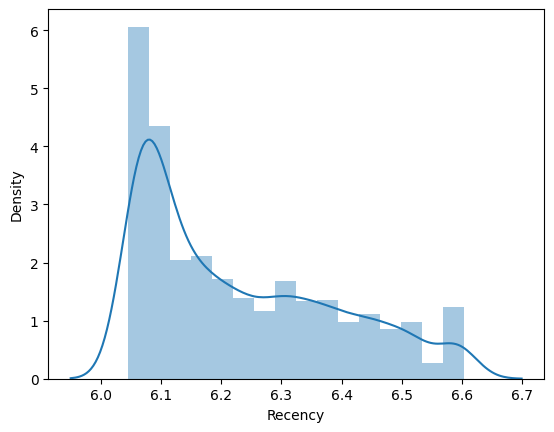

In [36]:
#Data distribution after data normalization for Recency
Recency_Plot = Log_Tfd_Data['Recency']
ax = sns.distplot(Recency_Plot)

<ipython-input-37-de88ace554c9>:3: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




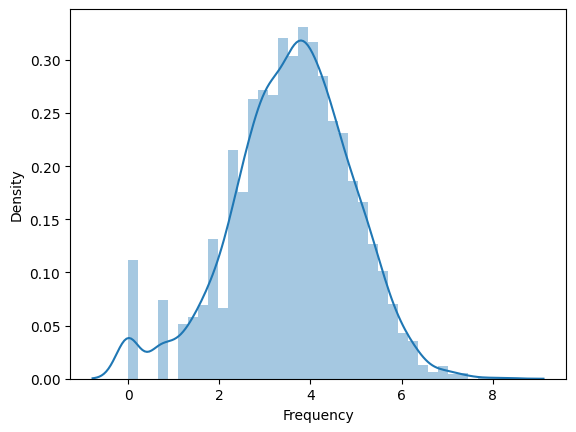

In [37]:
#Data distribution after data normalization for Frequency
Frequency_Plot = Log_Tfd_Data.query('Frequency < 1000')['Frequency']
ax = sns.distplot(Frequency_Plot)

<ipython-input-38-de7c9d814cb2>:3: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




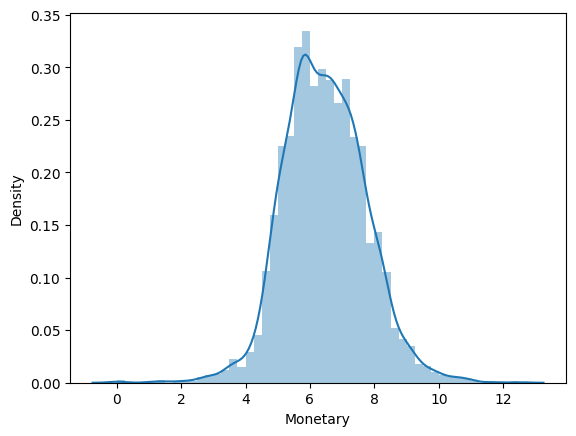

In [38]:
#Data distribution after data normalization for Monetary
Monetary_Plot = Log_Tfd_Data.query('Monetary < 10000')['Monetary']
ax = sns.distplot(Monetary_Plot)

In [39]:
from sklearn.preprocessing import StandardScaler

#Bring the data on same scale
scaleobj = StandardScaler()
Scaled_Data = scaleobj.fit_transform(Log_Tfd_Data)

#Transform it back to dataframe
Scaled_Data = pd.DataFrame(Scaled_Data, index = RFMScores.index, columns = Log_Tfd_Data.columns)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will chang

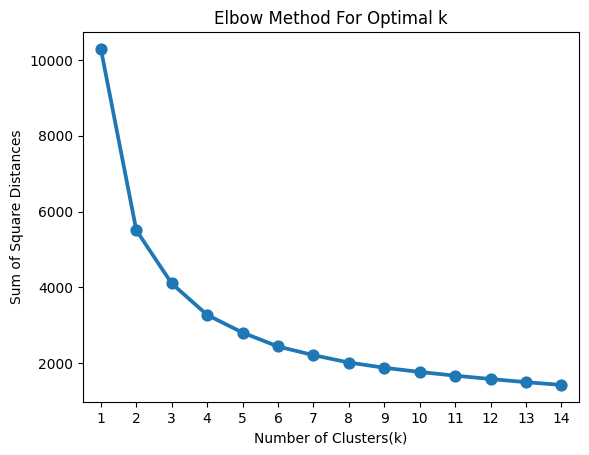

In [40]:
from sklearn.cluster import KMeans

sum_of_sq_dist = {}
for k in range(1,15):
    km = KMeans(n_clusters= k, init= 'k-means++', max_iter= 1000)
    km = km.fit(Scaled_Data)
    sum_of_sq_dist[k] = km.inertia_

#Plot the graph for the sum of square distance values and Number of Clusters
sns.pointplot(x = list(sum_of_sq_dist.keys()), y = list(sum_of_sq_dist.values()))
plt.xlabel('Number of Clusters(k)')
plt.ylabel('Sum of Square Distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [42]:
#Perform K-Mean Clustering or build the K-Means clustering model
KMean_clust = KMeans(n_clusters= 3, init= 'k-means++', max_iter= 1000)
KMean_clust.fit(Scaled_Data)

#Find the clusters for the observation given in the dataset
RFMScores['Cluster'] = KMean_clust.labels_
RFMScores.head()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



,Recency,Frequency,Monetary,R,F,M,RFMGroup,RFMScore,RFM_Loyalty_Level,Cluster
CustomerID,,,,,,,,,,
12346.0,529,33,372.86,3,3,3,333,9,Silver,2
12745.0,486,22,723.85,3,3,2,332,8,Gold,2
12746.0,540,17,254.55,3,3,4,334,10,Silver,1
12747.0,424,140,4327.22,1,1,1,111,3,Platinum,0
12748.0,423,1502,15078.20,1,1,1,111,3,Platinum,0


<Figure size 700x700 with 0 Axes>

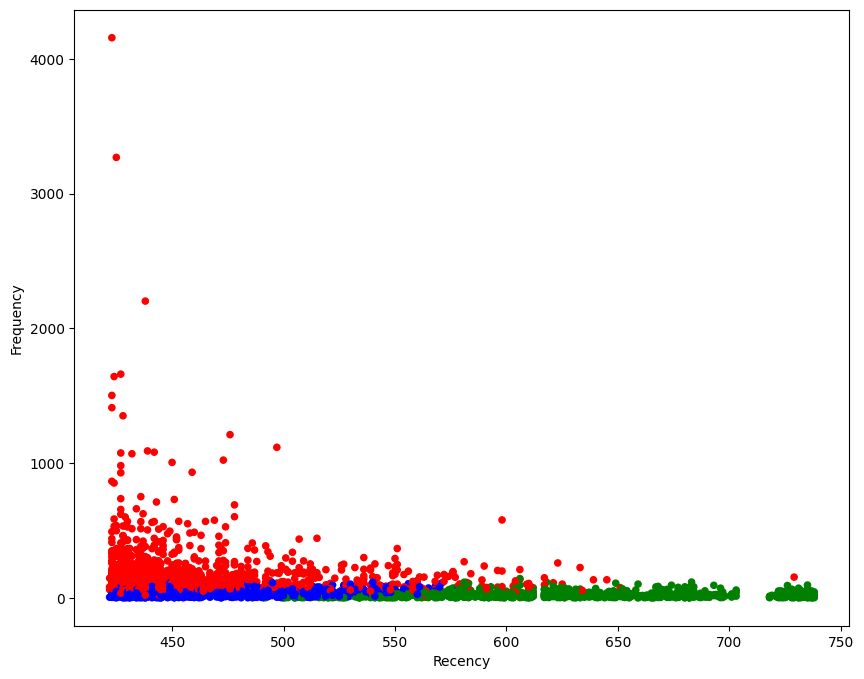

In [43]:
from matplotlib import pyplot as plt
plt.figure(figsize=(7,7))

##Scatter Plot Frequency Vs Recency
Colors = ["red", "green", "blue"]
RFMScores['Color'] = RFMScores['Cluster'].map(lambda p: Colors[p])
ax = RFMScores.plot(
    kind="scatter",
    x="Recency", y="Frequency",
    figsize=(10,8),
    c = RFMScores['Color']
)


In [44]:
RFMScores.head()

,Recency,Frequency,Monetary,R,F,M,RFMGroup,RFMScore,RFM_Loyalty_Level,Cluster,Color
CustomerID,,,,,,,,,,,
12346.0,529,33,372.86,3,3,3,333,9,Silver,2,blue
12745.0,486,22,723.85,3,3,2,332,8,Gold,2,blue
12746.0,540,17,254.55,3,3,4,334,10,Silver,1,green
12747.0,424,140,4327.22,1,1,1,111,3,Platinum,0,red
12748.0,423,1502,15078.20,1,1,1,111,3,Platinum,0,red
